# WASSA2023

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dependencies

In [2]:
repo_path = "https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/"
branch = "main"

In [3]:
!pip install transformers -q
!pip install accelerate -U -q
!pip install datasets -q
!pip install torch-summary -q
!pip install bertviz -q
!pip install NRCLex -q
!pip install textblob -q
!python -m textblob.download_corpora -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 88.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
utils_url = f"{repo_path}{branch}/utils.py"
evaluation_url = f"{repo_path}{branch}/evaluation.py"

import os
if os.path.exists("utils.py"):
  !rm "utils.py"
if os.path.exists("evaluation.py"):
  !rm "evaluation.py"

!wget {utils_url}
!wget {evaluation_url}

--2023-07-19 09:01:24--  https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38193 (37K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]  37.30K  --.-KB/s    in 0s      

2023-07-19 09:01:25 (113 MB/s) - ‘utils.py’ saved [38193/38193]

--2023-07-19 09:01:25--  https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/main/evaluation.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10675 (10K) [text/pla

In [5]:
import json
import torch
import importlib
import sys
from typing import Optional, Union, Tuple
import pandas as pd
import numpy as np
from torch import nn
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler
from transformers import (
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    TrainerCallback,
    EarlyStoppingCallback,
    BertModel,
    BertForSequenceClassification,
    RobertaForSequenceClassification,
    RobertaModel)
from transformers.modeling_outputs import SequenceClassifierOutput
from utils import *

<module 'utils' from '/content/utils.py'>

In [6]:
# set CUDA if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("======= CUDA Available =======")
else:
    device = torch.device('cpu')
    print("======= CUDA NOT Available, run on CPU =======")

======= CUDA Available =======


## Set up

In [7]:
EMOTIONS_NAMES = [
    'fear',
    'anger',
    'anticipation',
    'trust',
    'surprise',
    'positive',
    'negative',
    'sadness',
    'disgust',
    'joy',
    'hope'
]

config = {}

In [8]:
#@title Task type
TASK = "EMO"
EMO_binary_emotion = "neutral" #@param ["fear", "anger", "surprise", "sadness", "disgust", "joy", "hope", "neutral"]

In [9]:
#@title Number of labels
config['num_labels'] = 2

In [10]:
#@title Model Class
model_id = 'distil-1cls' #@param {type:"string"}
model_class_string = "RobertaPreTrainedModel" #@param ["BertPreTrainedModel", "RobertaPreTrainedModel"]
model_name = 'distilroberta-emotion' #@param ["bert-base", "roberta-base", "roberta-emotion", "distilroberta-emotion", "roberta-empathy"]

if model_class_string == "BertPreTrainedModel":
  model_class = BertForSequenceClassification
else:
  model_class = RobertaForSequenceClassification

config['model_id'] = model_id
config['model_class_string'] = model_class_string
config['model_name'] = model_name

In [53]:
#@title Global Features
bio_global = True #@param {type:"boolean"}
gold_empathy = False #@param {type:"boolean"}
gold_distress = False #@param {type:"boolean"}

global_features_names = []
bio = ['gender', 'age', 'income', 'race', 'education']
if bio_global:
  for b in bio: global_features_names.append(b)

if gold_empathy: global_features_names.append('empathy')
if gold_distress: global_features_names.append('distress')

config['bio_global'] = bio_global
config['gold_empathy'] = gold_empathy
config['gold_distress'] = gold_distress
config['global_features_names'] = global_features_names

dim_extra_features = 0

In [54]:
#@title Prompt
bio_prompt = True #@param {type:"boolean"}
bio_sep = 'after SEP' #@param ["after SEP", "before SEP"]
empathy_prompt = False #@param {type:"boolean"}
emp_sep = 'before SEP' #@param ["after SEP", "before SEP"]

prompt_names_before_SEP = []
prompt_names_after_SEP = []
if bio_prompt:
    if bio_sep=='before SEP':
        prompt_names_before_SEP.append('prompt_bio')
    else:
        prompt_names_after_SEP.append('prompt_bio')
if empathy_prompt:
    if emp_sep=='before SEP':
        prompt_names_before_SEP.append('prompt_emp')
    else:
        prompt_names_after_SEP.append('prompt_emp')

config['bio_prompt'] = bio_prompt
config['empathy_prompt'] = empathy_prompt
config['prompt_names_before_SEP'] = prompt_names_before_SEP
config['prompt_names_after_SEP'] = prompt_names_after_SEP

In [55]:
#@title Last CLSs
n_last_cls = 1 #@param {type:"integer"}
mean_last_cls = False #@param {type: "boolean"}
concat_local_features = False #@param {type: "boolean"}
config['n_last_cls'] = n_last_cls
config['mean_last_cls'] = mean_last_cls

config['dim_extra_features'] = len(global_features_names)

In [56]:
#@title Model configuration
train_batch_size = 8 #@param {type:"integer"}
val_batch_size = 8 #@param {type:"integer"}
learning_rate = 5e-5 #@param {type:"number"}
weight_decay = 0.08 #@param {type:"number"}
epochs = 30 #@param {type:"integer"}
patience = 5 #@param {type:"integer"}
dropout = 0.3 #@param {type:"number"}
weighted_loss = "None" #@param ["None", "normalized_inverse", "balanced"]

model_type ={
  'distilroberta-emotion':'j-hartmann/emotion-english-distilroberta-base',
  'roberta-emotion':'j-hartmann/emotion-english-roberta-large',
  'roberta-empathy': 'bdotloh/roberta-base-empathy',
  'bert-base': 'bert-base-cased',
  'roberta-base' : 'roberta-base'
}

model_config = {
    'model_id': model_id,
    'tokenizer_name': model_type.get(model_name),
    'model_name': model_type.get(model_name),
    'train_batch_size': train_batch_size,
    'val_batch_size': val_batch_size,
    'learning_rate': learning_rate,
    'weight_decay': weight_decay,
    'epochs': epochs,
    'seed': 42,
    'patience': patience,
    'early_stopping_threshold': 0,
    'weighted_loss': weighted_loss,
    'dropout' : dropout
}



In [57]:
path_tosave = f"{TASK}_{model_config['model_id']}"
!mkdir $path_tosave

config.update(model_config)
write_dict_to_json(config, f"{path_tosave}/config.json")

print("\nCONFIGURATION")
for k,v in config.items():
  print(f"{k}: {v}")

mkdir: cannot create directory ‘EMOBin_distil-1cls’: File exists

CONFIGURATION
num_labels: 2
model_id: distil-1cls
model_class_string: RobertaPreTrainedModel
model_name: j-hartmann/emotion-english-distilroberta-base
bio_global: True
gold_empathy: False
gold_distress: False
global_features_names: ['gender', 'age', 'income', 'race', 'education']
bio_prompt: True
empathy_prompt: False
prompt_names_before_SEP: []
prompt_names_after_SEP: ['prompt_bio']
n_last_cls: 1
mean_last_cls: False
dim_extra_features: 5
tokenizer_name: j-hartmann/emotion-english-distilroberta-base
train_batch_size: 8
val_batch_size: 8
learning_rate: 5e-05
weight_decay: 0.08
epochs: 30
seed: 42
patience: 5
early_stopping_threshold: 0
weighted_loss: None
dropout: 0.3


## Dataset

### WASSA dataset

In [58]:
class WASSADataset(Dataset):

    def __init__(
        self,
        tokenizer,
        essay,
        targets,
        prompt_before_SEP=None,
        prompt_after_SEP=None,
        global_features = None,
        max_len=None
        ):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.essay = essay
        self.targets = targets
        self.prompt_before_SEP = prompt_before_SEP
        self.prompt_after_SEP = prompt_after_SEP
        self.global_features = global_features

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        essay = str(self.essay[index])

        prompt_before_SEP = ""
        if self.prompt_before_SEP is not None:
          for p in self.prompt_before_SEP[index]:
            prompt_before_SEP += " " + str(p)

        prompt_after_SEP = ""
        if self.prompt_after_SEP is not None:
          for p in self.prompt_after_SEP[index]:
            prompt_after_SEP += " " + str(p)

        text = essay
        text_pair = None
        if prompt_before_SEP != "":
          text += str(prompt_before_SEP)
        if prompt_after_SEP != "":
          text_pair = str(prompt_after_SEP)

        inputs = self.tokenizer.encode_plus(
            text=essay,
            text_pair=text_pair,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
            return_token_type_ids=True
        )

        item = {
          'input_ids': inputs['input_ids'].flatten(),
          'attention_mask': inputs['attention_mask'].flatten(),
          'token_type_ids': inputs["token_type_ids"].flatten()
        }

        if self.targets is not None:
          item['labels'] = torch.FloatTensor(self.targets[index])

        if self.global_features is not None:
          item['global_features'] = torch.FloatTensor(self.global_features[index])

        return item

Read dataframes

In [59]:
TRAIN_DATA = f"{repo_path}{branch}/datasets/WASSA23_essay_level_train_preproc_upsampled.tsv"
all_train_df = pd.read_csv(TRAIN_DATA, sep='\t')
train_df, val_df = split_train_val(all_train_df, val_size=0.1)
DEV_DATA = f"{repo_path}{branch}/datasets/WASSA23_essay_level_dev_preproc.tsv"
dev_df = pd.read_csv(DEV_DATA, sep='\t')

Encode targets

In [103]:
y_train = np.array(train_df[EMO_binary_emotion])
y_val = np.array(val_df[EMO_binary_emotion])

y_train = [[0, 1] if label == 1 else [1, 0] for label in y_train]
y_val = [[0, 1] if label == 1 else [1, 0] for label in y_val]

y_dev = []
for emo in dev_df['emotion']:
  if EMO_binary_emotion in emo:
    y_dev.append(1)
  else:
    y_dev.append(0)
y_dev = [[0, 1] if label == 1 else [1, 0] for label in y_dev]

Extra global features

In [104]:
global_features_train = None
global_features_val = None
global_features_dev = None

if len(config.get('global_features_names')) > 0:
  scaler = StandardScaler()
  scaler.fit(np.array(train_df[config.get('global_features_names')]))

  def standard_scalar_features(features):
    return scaler.transform(features)

  global_features_train =  standard_scalar_features(np.array(train_df[config.get('global_features_names')]))
  global_features_val =  standard_scalar_features(np.array(val_df[config.get('global_features_names')]))
  global_features_dev =  standard_scalar_features(np.array(dev_df[config.get('global_features_names')]))

Prompt

In [105]:
prompt_before_SEP_train = None
prompt_after_SEP_train = None
prompt_before_SEP_val = None
prompt_after_SEP_val = None
prompt_before_SEP_dev = None
prompt_after_SEP_dev = None

if len(config.get('prompt_names_before_SEP')) > 0:
  prompt_before_SEP_train = np.array(train_df[config.get('prompt_names_before_SEP')])
  prompt_before_SEP_val = np.array(val_df[config.get('prompt_names_before_SEP')])
  prompt_before_SEP_dev = np.array(dev_df[config.get('prompt_names_before_SEP')])

if len(config.get('prompt_names_after_SEP')) > 0:
  prompt_after_SEP_train = np.array(train_df[config.get('prompt_names_after_SEP')])
  prompt_after_SEP_val = np.array(val_df[config.get('prompt_names_after_SEP')])
  prompt_after_SEP_dev = np.array(dev_df[config.get('prompt_names_after_SEP')])

## Model

In [106]:
def get_loss_weights(y, method):
  if method == 'balanced':
    weights_train = y.shape[0] / (y.shape[1] * np.sum(y, axis=0))
  else:
    inverse_n_samples = 1 / np.sum(y, axis=0)
    sum_inverses = sum(inverse_n_samples)
    weights_train = inverse_n_samples / sum_inverses
  return torch.cuda.FloatTensor(weights_train)

In [107]:
loss_weights_train = None
if model_config.get('weighted_loss')!='None':
  loss_weights_train = get_loss_weights(y_train, model_config.get('weighted_loss'))

### Custom model

In [108]:
class ClassificationHead(nn.Module):
    #Head for sentence-level classification tasks.

    def __init__(self, config, dim_extra_features, hidden_layers_to_concat, classifier_dropout, mean_last_cls):
        super().__init__()

        if mean_last_cls:
          total_dims = config.hidden_size + dim_extra_features
        else:
          total_dims = config.hidden_size*hidden_layers_to_concat + dim_extra_features
        self.dense = nn.Linear(total_dims, total_dims)
        self.dropout = nn.Dropout(classifier_dropout)
        self.out_proj = nn.Linear(total_dims, config.num_labels)

    def forward(self, features, **kwargs):
        features = features.to(torch.float32) # by default float32 is used as the dtype
        x = self.dense(features)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

class CustomSequenceClassification(model_class):

    def __init__(self, config, dim_extra_features=0, model_class = None, loss_weights=None, n_last_cls = 1, mean_last_cls = False):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config
        self.loss_weights = loss_weights
        self.n_last_cls = n_last_cls
        self.mean_last_cls = mean_last_cls
        self.model_class = model_class
        if self.model_class == "BertPreTrainedModel":
          self.bert = BertModel(config)

        if self.model_class == "RobertaPreTrainedModel":
          self.roberta = RobertaModel(config)

        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.classifier = ClassificationHead(config,
                                            dim_extra_features,
                                            n_last_cls,
                                            classifier_dropout,
                                            mean_last_cls)
        self.post_init()


    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        global_features = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = True,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, SequenceClassifierOutput]:

        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if self.model_class == "BertPreTrainedModel":
          outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        if self.model_class == "RobertaPreTrainedModel":
          outputs = self.roberta(
              input_ids,
              attention_mask=attention_mask,
              token_type_ids=token_type_ids,
              position_ids=position_ids,
              head_mask=head_mask,
              inputs_embeds=inputs_embeds,
              output_attentions=output_attentions,
              output_hidden_states=output_hidden_states,
              return_dict=return_dict,
          )

        cls_tokens = []
        for i in range(1, self.n_last_cls + 1):
            cls_tokens.append(outputs.hidden_states[-1 * i][:, 0, :])
        if self.mean_last_cls:
          # average cls tokens
          output = torch.mean(torch.stack(cls_tokens), dim=0)
        else:
          # concat cls tokens
          output = torch.cat(cls_tokens, dim=1)

        output = self.dropout(output)

        if global_features is not None: # global
          output = torch.cat((output, global_features), dim=-1)

        logits = self.classifier(output)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = nn.MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = nn.CrossEntropyLoss(weight = self.loss_weights)
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = nn.BCEWithLogitsLoss(weight = self.loss_weights)
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


In [110]:
tokenizer = AutoTokenizer.from_pretrained(config.get('tokenizer_name'), truncation=True)
tokenizer

RobertaTokenizerFast(name_or_path='j-hartmann/emotion-english-distilroberta-base', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)}, clean_up_tokenization_spaces=True)

In [111]:
model = CustomSequenceClassification.from_pretrained(
  config.get('model_name'),
  dim_extra_features=config.get('dim_extra_features'),
  model_class = config.get('model_class_string'),
  problem_type = "multi_label_classification",
  num_labels = config.get('num_labels'),
  classifier_dropout = config.get('dropout'),
  ignore_mismatched_sizes=True
)

model

Some weights of CustomSequenceClassification were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of CustomSequenceClassification were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized because the shapes did not match:
- classifier.dense.weight: found shape torch.Size([768, 768]) in the checkpoint and torch.Size([773, 773]) in the model instantiated
- classifier.dense.bias: found shape torch.Size([768]) in the checkpoint and torch.Size([773]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([2, 773]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([7]) in the checkpoint

CustomSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Laye

## Training

Prepare datasets

In [112]:
train_set = WASSADataset(
    tokenizer=tokenizer,
    essay=train_df.essay,
    prompt_before_SEP=prompt_before_SEP_train,
    prompt_after_SEP=prompt_after_SEP_train,
    global_features = global_features_train,
    targets = y_train
    )

val_set = WASSADataset(
    tokenizer=tokenizer,
    essay=val_df.essay,
    prompt_before_SEP=prompt_before_SEP_val,
    prompt_after_SEP=prompt_after_SEP_val,
    global_features = global_features_val,
    targets = y_val
    )

dev_set = WASSADataset(
    tokenizer=tokenizer,
    essay=dev_df.essay,
    prompt_before_SEP=prompt_before_SEP_dev,
    prompt_after_SEP=prompt_after_SEP_dev,
    global_features = global_features_dev,
    targets = y_dev
    )

Set up training

In [113]:
metric_for_val ='eval_macro_f1'
train_arguments = TrainingArguments(
    output_dir=f"./{config.get('model_name')}",
    per_device_train_batch_size = config.get('train_batch_size'),
    per_device_eval_batch_size = config.get('val_batch_size'),
    num_train_epochs = config.get('epochs'),
    evaluation_strategy = "steps",
    save_strategy = "steps",
    logging_strategy = "steps",
    logging_steps = 150,
    eval_steps = 150,
    save_steps = 150,
    learning_rate=config.get('learning_rate'),
    weight_decay=config.get('weight_decay'),
    load_best_model_at_end=True,
    metric_for_best_model = metric_for_val,
    seed=config.get('seed'),
)

In [114]:
trainer = Trainer(
    model=model,
    args=train_arguments,
    train_dataset=train_set,
    eval_dataset=val_set,
    tokenizer=tokenizer,
    compute_metrics=compute_EMO_metrics_trainer
)

Callbacks

In [115]:
class TrainerLoggingCallback(TrainerCallback):
    def __init__(self, log_path):
        self.log_path = log_path

    def on_log(self, args, state, control, logs=None, **kwargs):
        _ = logs.pop("total_flos", None)
        if state.is_local_process_zero: # whether this process is the main one in a distributed setting
            with open(self.log_path, "a") as f:
                f.write(json.dumps(logs) + "\n")

trainer.add_callback(EarlyStoppingCallback(
    early_stopping_patience = config.get('patience'),
    early_stopping_threshold = config.get('early_stopping_threshold')))

trainer.add_callback(TrainerLoggingCallback(config.get('model_id')+"_log.json"))

Start training

In [116]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Macro F1,Micro F1,Micro Jaccard,Macro Precision,Macro Recall,Micro Precision,Micro Recall,Sklearn Accuracy,Roc Auc Micro
150,0.442800,0.389245,0.618238,0.843478,0.729323,0.725795,0.596390,0.843478,0.843478,0.843478,0.843478
300,0.462400,0.387889,0.503801,0.837681,0.720698,0.794355,0.524120,0.837681,0.837681,0.837681,0.837681
450,0.422300,0.400703,0.573269,0.846377,0.733668,0.788786,0.563739,0.846377,0.846377,0.846377,0.846377
600,0.394200,0.552553,0.545411,0.840580,0.725000,0.755952,0.546498,0.840580,0.840580,0.840580,0.840580
750,0.390000,0.344882,0.729045,0.872464,0.773779,0.793824,0.696353,0.872464,0.872464,0.872464,0.872464
900,0.355400,0.470339,0.636715,0.860870,0.755725,0.837861,0.606842,0.860870,0.860870,0.860870,0.860870
1050,0.348900,0.520976,0.564394,0.849275,0.738035,0.861832,0.558603,0.849275,0.849275,0.849275,0.849275
1200,0.321000,0.393746,0.734329,0.884058,0.792208,0.855509,0.689565,0.884058,0.884058,0.884058,0.884058
1350,0.295600,0.429692,0.671289,0.863768,0.760204,0.805901,0.636099,0.863768,0.863768,0.863768,0.863768
1500,0.263500,0.434374,0.637066,0.846377,0.733668,0.732812,0.611889,0.846377,0.846377,0.846377,0.846377


TrainOutput(global_step=2400, training_loss=0.30739149808883665, metrics={'train_runtime': 1292.7972, 'train_samples_per_second': 69.292, 'train_steps_per_second': 8.679, 'train_loss': 0.30739149808883665, 'epoch': 6.42})

In [117]:
# Access the training logs
train_logs = trainer.state.log_history

metrics = [list(log.keys())[:-5] for log in train_logs if log.get('eval_loss') is not None][0]

train_loss_values = []
eval_loss_values = []
eval_metrics_values = []
for _ in metrics:
  eval_metrics_values.append([])
train_epochs = []
eval_epochs = []

best_metric = 0
best_train_loss = float('inf')
best_eval_loss = float('inf')

for log in train_logs:

  if log.get(metric_for_val) is not None:

    if log.get(metric_for_val) > best_metric:
      best_metric = log.get(metric_for_val)
      best_steps = log.get('step')
      best_epoch_metric = log.get('epoch')
    if log.get('eval_loss') < best_eval_loss:
      best_eval_loss = log.get('eval_loss')
      best_epoch_eval_loss = log.get('epoch')

    for i, metric in enumerate(metrics):
      eval_metrics_values[i].append(log.get(metric))

    eval_loss_values.append(log.get('eval_loss'))
    eval_epochs.append(log.get('epoch'))

  if log.get('loss') is not None:
    if log.get('loss') < best_train_loss:
      best_train_loss = log.get('loss')

    train_loss_values.append(log.get('loss'))
    train_epochs.append(log.get('epoch'))


Plot losses

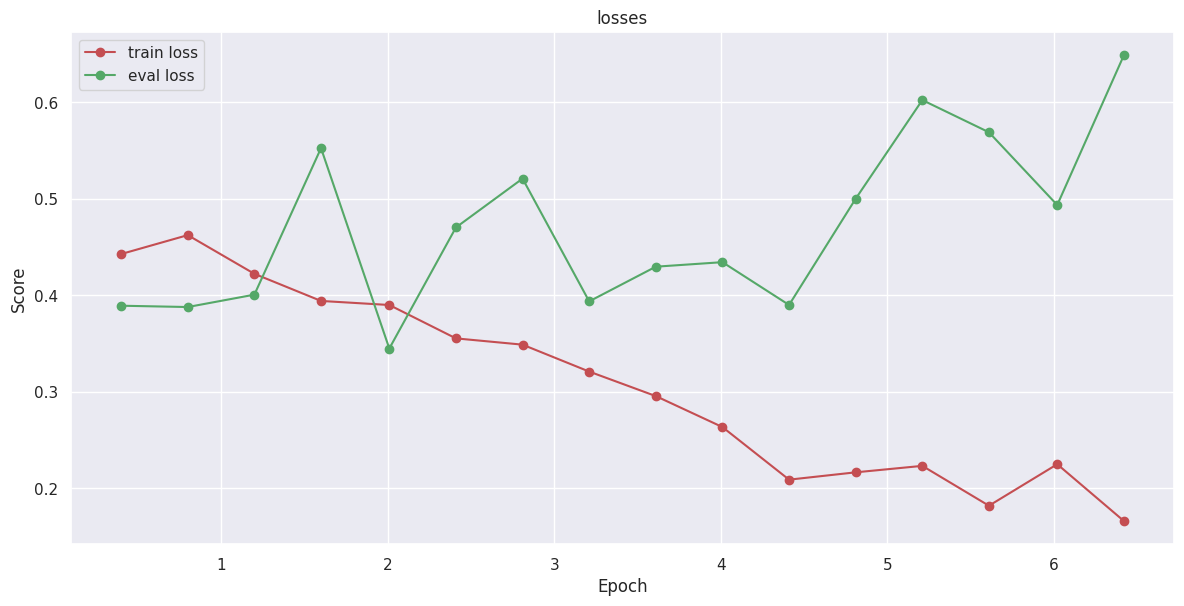

In [118]:
fig_name = "losses"
plot_metric_curve(
    values = [train_loss_values, eval_loss_values],
    epochs = [train_epochs, eval_epochs],
    metrics = ["train loss", "eval loss"],
    title = fig_name,
    path = f"{path_tosave}/{fig_name}.png")

Plot metrics

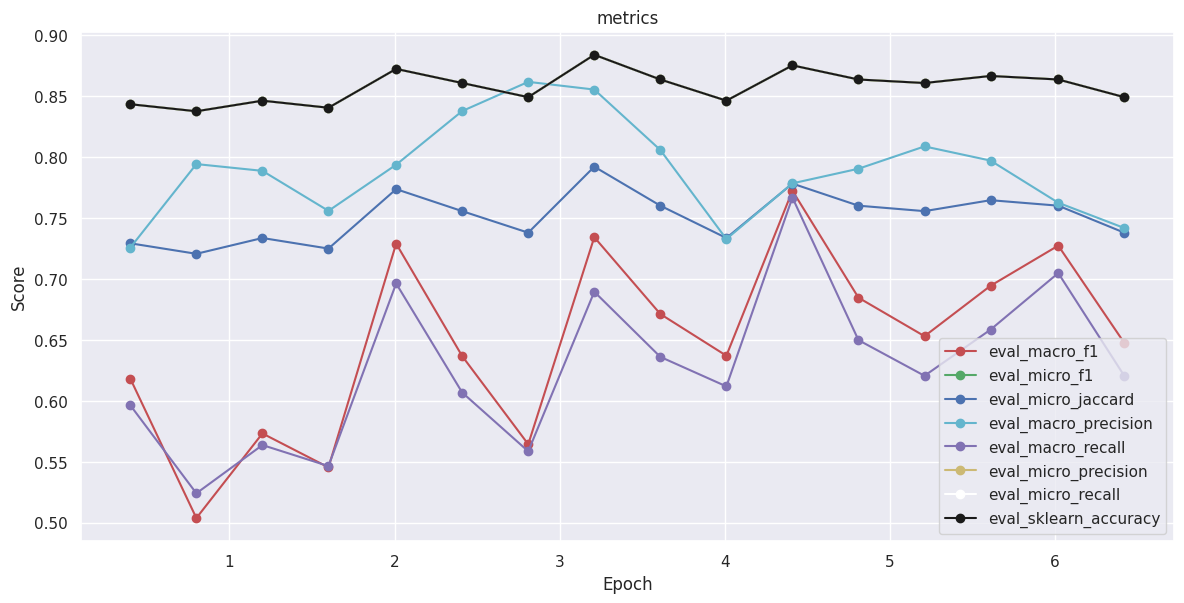

In [119]:
fig_name = "metrics"
plot_metric_curve(
    values = eval_metrics_values[1:],
    epochs = [eval_epochs for _ in eval_metrics_values[1:]],
    metrics = metrics[1:],
    title = fig_name,
    path = f"{path_tosave}/{fig_name}.png")

## Evaluation

In [120]:
print(trainer.state.best_model_checkpoint)
outs = trainer.predict(dev_set)

./j-hartmann/emotion-english-distilroberta-base/checkpoint-1650


In [121]:
save_logits(outs.predictions[0], [f'no-{EMO_binary_emotion}', EMO_binary_emotion],f"{path_tosave}/logits_{EMO_binary_emotion}.tsv")
predictions = np.argmax(outs.predictions[0], axis=1)
predictions = np.where(predictions==0, f'no-{EMO_binary_emotion}', EMO_binary_emotion)
golds = np.argmax(outs.label_ids, axis=1)
golds = np.where(golds==0, f'no-{EMO_binary_emotion}', EMO_binary_emotion)

In [122]:
path_predictions = f"{path_tosave}/predictions_{TASK}.tsv"
path_metrics = f"{path_tosave}/dev_metrics_{TASK}.json"

scores = {
    'train_loss': float(best_train_loss),
    'eval_loss': float(best_eval_loss)
}

write_predictions(predictions, path_predictions)
challenge_metrics = compute_metrics(golds=golds, predictions=predictions, task=TASK)
scores.update(challenge_metrics)
scores['best_metric'] = float(best_metric)
scores['best_epoch_metric'] = float(best_epoch_metric)
scores['best_epoch_eval_loss'] =  float(best_epoch_eval_loss)

write_dict_to_json(scores, path_metrics)

scores

{'train_loss': 0.1662,
 'eval_loss': 0.34488219022750854,
 'macro_f1': 0.681,
 'micro_f1': 0.7981,
 'micro_jaccard': 0.664,
 'macro_precision': 0.7627,
 'macro_recall': 0.6592,
 'micro_precision': 0.7981,
 'micro_recall': 0.7981,
 'best_metric': 0.7724728148341284,
 'best_epoch_metric': 4.41,
 'best_epoch_eval_loss': 2.01}

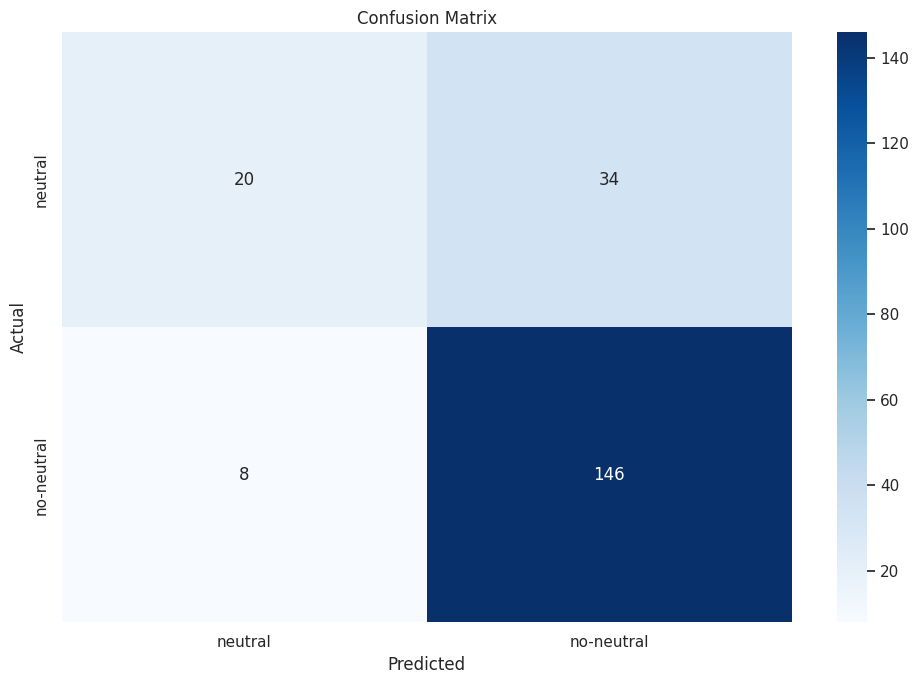

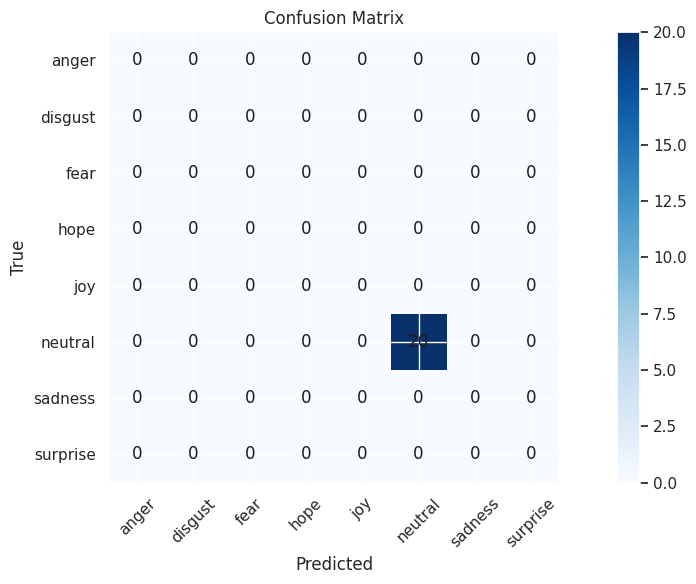

In [123]:
fig_name = "confusion_matrix"
plot_confusion_matrix(golds=golds,
                      predictions=predictions,
                      path= f"{path_tosave}/{fig_name}.png"
                      )
print("\n")
fig_name = "confusion_matrix_per_emotions"
plot_confusion_matrix_per_emotions(gold_emotions = golds,
                                    predicted_emotions = predictions,
                                    path= f"{path_tosave}/{fig_name}.png"
                                  )

## Save on Google Drive

In [126]:
# move the best checkpoint in the folder with model id
best_model_path = trainer.state.best_model_checkpoint

!mv $best_model_path /content/$path_tosave

In [127]:
# move the checkpoint with best metric in the folder with model id
!mv $best_metric_path /content/$path_tosave

In [128]:
# move the results to personal drive
!mv /content/$path_tosave /content/drive/MyDrive/hlt